In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer


In [ ]:
hearing = pd.read_csv('hearing survey.csv', encoding="utf-8")
hearing = hearing.drop_duplicates()
hearing = hearing.fillna("Unknown")


print(hearing.head())
print(hearing.columns)

                           Perceived_Hearing_Meaning Hearing_FOMO  \
0  Staying independent and alert, Enjoying music,...    Sometimes   
1  Staying independent and alert, Staying connect...       Rarely   
2  Staying independent and alert, I havenâ€™t tho...       Rarely   
3                      Staying independent and alert    Yes often   
4                      Staying independent and alert        Never   

  Hearing_Test_Barrier                            Missed_Important_Sounds  \
0                 Cost                       Yes, in family conversations   
1  Never felt the need  Yes, in public spaces (trains, shops, announce...   
2                Shame      Yes, during important work or school meetings   
3    Lack of awareness      Yes, during important work or school meetings   
4    Lack of awareness                     No, I usually hear things well   

  Left_Out_Due_To_Hearing Daily_Headphone_Use  Belief_Early_Hearing_Care  \
0              Yes, often        My parent(s) 

In [ ]:
hearing['Interest_in_Hearing_App'] = hearing['Interest_in_Hearing_App'].str.lower().replace({
    "yes, that would be helpful": "yes",
    "yes often": "yes",
    "no, i don't think it's necessary": "no"
})


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
features = hearing['Desired_App_Features'].dropna().str.split(', ')
expanded = pd.DataFrame(mlb.fit_transform(features), columns=mlb.classes_, index=features.index)

hearing = hearing.join(expanded)


In [ ]:


age_order = ['18 - 24', '25 - 34', '35 - 44', '45 - 54', '55 - 64', '65+']
if 'Age_group' in hearing.columns:
    hearing['Age_group'] = hearing['Age_group'].apply(lambda x: x if x in age_order else 'Unknown')
    hearing['Age_group'] = pd.Categorical(hearing['Age_group'], categories=age_order + ['Unknown'], ordered=True)

if 'Hearing_FOMO' in hearing.columns:
    map_fomo = {'never': 0, 'rarely': 1, 'sometimes': 2, 'yes': 3, 'unknown': 0}
    hearing['hearing_fomo_num'] = hearing['Hearing_FOMO'].str.lower().map(map_fomo).fillna(0).astype(int)

if 'Belief_Early_Hearing_Care' in hearing.columns:
    hearing['Belief_Early_Hearing_Care'] = pd.to_numeric(hearing['Belief_Early_Hearing_Care'], errors='coerce')
    hearing['Belief_Early_Hearing_Care'] = hearing['Belief_Early_Hearing_Care'].fillna(hearing['Belief_Early_Hearing_Care'].median()).astype(int)

if 'Ear_Discomfort_After_Use' in hearing.columns:
    map_discomfort = {'no': 0, 'maybe': 1, 'occasionally': 1, 'sometimes': 1, 'yes': 2}
    hearing['ear_discomfort_num'] = hearing['Ear_Discomfort_After_Use'].str.lower().map(map_discomfort).fillna(0).astype(int)

if 'Daily_Headphone_Use' in hearing.columns:
    def headphone_score(x):
        if not isinstance(x, str): return 0
        x = x.lower()
        if 'less than 1' in x: return 1
        if '1-2' in x: return 2
        if '3' in x or 'more than 2' in x: return 3
        return 0
    hearing['daily_headphone_score'] = hearing['Daily_Headphone_Use'].apply(headphone_score)

if 'Desired_App_Features' in hearing.columns:
    features = hearing['Desired_App_Features'].fillna('').apply(lambda s: [x.strip() for x in s.split(',') if x.strip()])
    mlb = MultiLabelBinarizer()
    expanded = pd.DataFrame(mlb.fit_transform(features), columns=mlb.classes_, index=hearing.index)
    hearing = pd.concat([hearing, expanded], axis=1)

hearing['Concern_Score'] = hearing[['hearing_fomo_num',
                                    'ear_discomfort_num',
                                    'daily_headphone_score']].sum(axis=1)


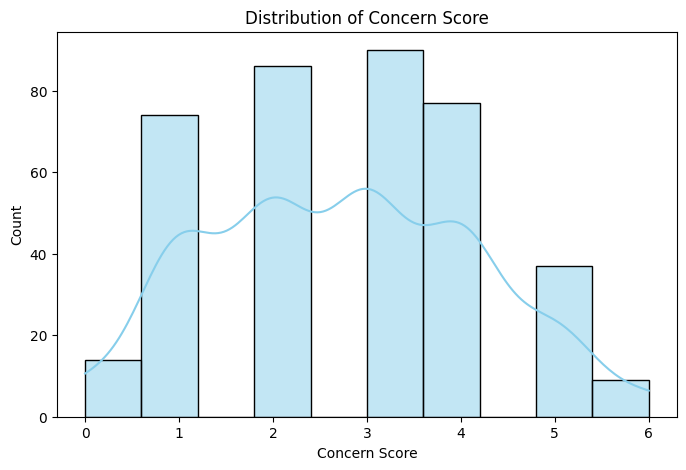

/tmp/ipython-input-2667005252.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Age_group", y="Concern_Score", data=hearing, palette="Set2")


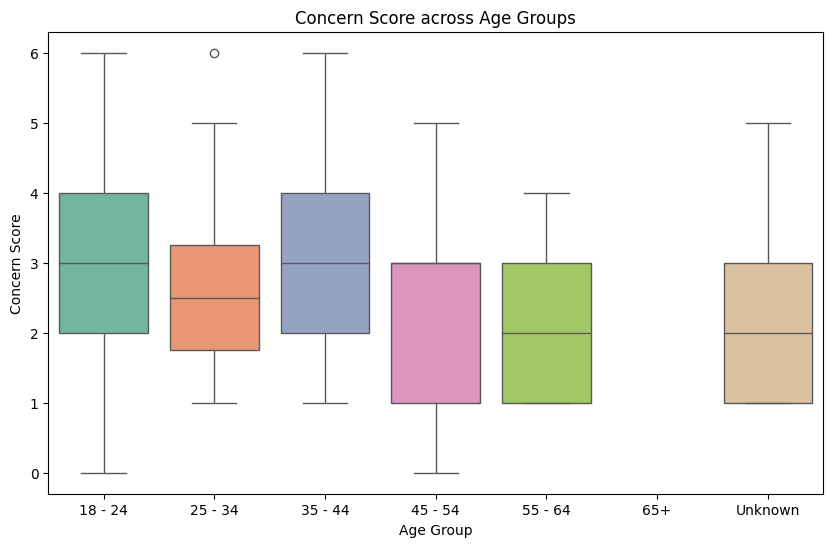

/tmp/ipython-input-2667005252.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="daily_headphone_score", y="Concern_Score", data=hearing, palette="muted")


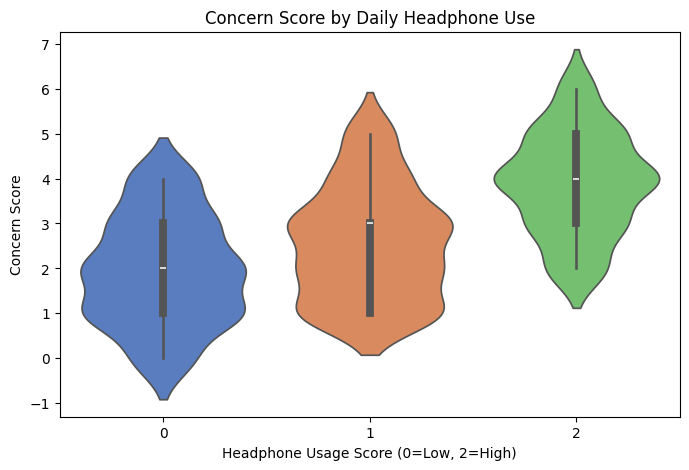

/tmp/ipython-input-2667005252.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_counts.values, y=feature_counts.index, palette="viridis")


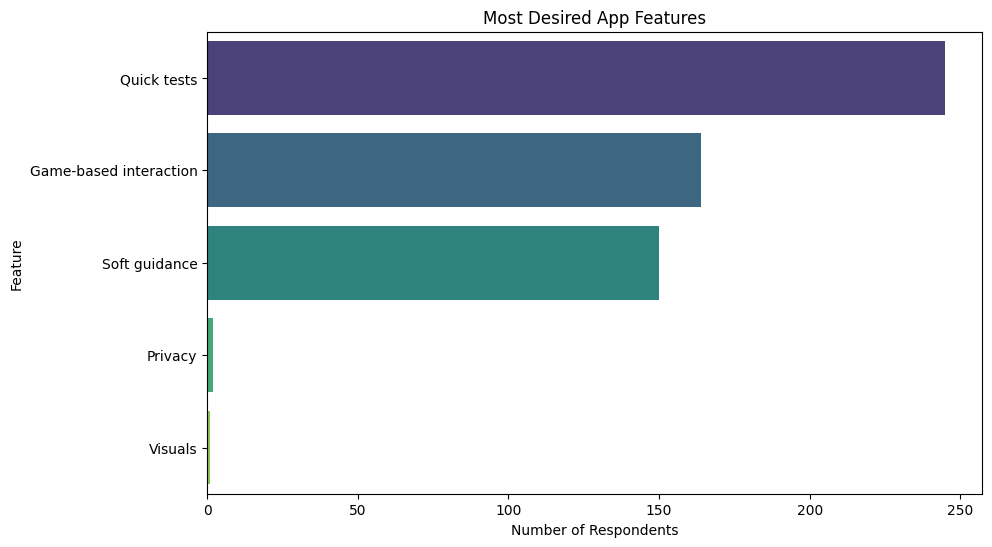

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(hearing['Concern_Score'], bins=10, kde=True, color="skyblue")
plt.title("Distribution of Concern Score")
plt.xlabel("Concern Score")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x="Age_group", y="Concern_Score", data=hearing, palette="Set2")
plt.title("Concern Score across Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Concern Score")
plt.show()


plt.figure(figsize=(8,5))
sns.violinplot(x="daily_headphone_score", y="Concern_Score", data=hearing, palette="muted")
plt.title("Concern Score by Daily Headphone Use")
plt.xlabel("Headphone Usage Score (0=Low, 2=High)")
plt.ylabel("Concern Score")
plt.show()

if 'Desired_App_Features' in hearing.columns:
    feature_cols = [col for col in hearing.columns if col in ['Privacy','Visuals','Soft guidance','Report sharing','Quick tests','Game-based interaction','Detailed feedback','AI Support']]
    if feature_cols:
        feature_counts = hearing[feature_cols].sum().sort_values(ascending=False)
        plt.figure(figsize=(10,6))
        sns.barplot(x=feature_counts.values, y=feature_counts.index, palette="viridis")
        plt.title("Most Desired App Features")
        plt.xlabel("Number of Respondents")
        plt.ylabel("Feature")
        plt.show()
